# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
import experiments.utils.drawing

In [2]:
metaserieses = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
serieses = [1, 2, 3, 21, 22, 23, 41, 42, 43, 61, 62, 63, 81, 82, 83]

series_meta = {
    "lstm": {"video": 1, "audio-qa": 21, "audio-sent": 41, "sum-qa": 61, "nlp": 81},
    "reactive": {"video": 2, "audio-qa": 22, "audio-sent": 42, "sum-qa": 62, "nlp": 82},
    "baseline": {"video": 3, "audio-qa": 23, "audio-sent": 43, "sum-qa": 63, "nlp": 83},
}


series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
series_paths

{1: '/home/cc/ipa-private/data/results/final/metaseries/15/series/1',
 2: '/home/cc/ipa-private/data/results/final/metaseries/15/series/2',
 3: '/home/cc/ipa-private/data/results/final/metaseries/15/series/3',
 21: '/home/cc/ipa-private/data/results/final/metaseries/15/series/21',
 22: '/home/cc/ipa-private/data/results/final/metaseries/15/series/22',
 23: '/home/cc/ipa-private/data/results/final/metaseries/15/series/23',
 41: '/home/cc/ipa-private/data/results/final/metaseries/15/series/41',
 42: '/home/cc/ipa-private/data/results/final/metaseries/15/series/42',
 43: '/home/cc/ipa-private/data/results/final/metaseries/15/series/43',
 61: '/home/cc/ipa-private/data/results/final/metaseries/15/series/61',
 62: '/home/cc/ipa-private/data/results/final/metaseries/15/series/62',
 63: '/home/cc/ipa-private/data/results/final/metaseries/15/series/63',
 81: '/home/cc/ipa-private/data/results/final/metaseries/15/series/81',
 82: '/home/cc/ipa-private/data/results/final/metaseries/15/series/82'

In [4]:
loaders

{1: <experiments.utils.parser.AdaptationParser at 0x7fd36f8592b0>,
 2: <experiments.utils.parser.AdaptationParser at 0x7fd4404eef40>,
 3: <experiments.utils.parser.AdaptationParser at 0x7fd44049f1f0>,
 21: <experiments.utils.parser.AdaptationParser at 0x7fd4404e3c40>,
 22: <experiments.utils.parser.AdaptationParser at 0x7fd4404f3f10>,
 23: <experiments.utils.parser.AdaptationParser at 0x7fd4404f3f40>,
 41: <experiments.utils.parser.AdaptationParser at 0x7fd4404e7e80>,
 42: <experiments.utils.parser.AdaptationParser at 0x7fd440373eb0>,
 43: <experiments.utils.parser.AdaptationParser at 0x7fd36f859fd0>,
 61: <experiments.utils.parser.AdaptationParser at 0x7fd36f8578e0>,
 62: <experiments.utils.parser.AdaptationParser at 0x7fd4403736a0>,
 63: <experiments.utils.parser.AdaptationParser at 0x7fd440373400>,
 81: <experiments.utils.parser.AdaptationParser at 0x7fd36f8544f0>,
 82: <experiments.utils.parser.AdaptationParser at 0x7fd36f87b6d0>,
 83: <experiments.utils.parser.AdaptationParser at 

In [5]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 1 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 8,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 1e-06,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'metaseries': 7,
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                   

In [6]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [7]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{1: False,
 2: False,
 3: False,
 21: False,
 22: False,
 23: False,
 41: False,
 42: False,
 43: False,
 61: False,
 62: False,
 63: False,
 81: False,
 82: False,
 83: False}

In [8]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [9]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Total core changes

In [10]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]

# -----------------------------
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]

# -----------------------------

total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
xlabel = "Pipelines"
legend = "Predictor"

for exp, value in total_core_changes.items():
    value["total"] = (np.array(value["total"]) / len(value["total"])).tolist()
total_core_changes_total = {
    key: value["total"] for key, value in total_core_changes.items()
}

In [11]:
import importlib

importlib.reload(experiments.utils.drawing)

# experiments.utils.drawing.draw_cumulative_with_grouping(
#     dict_to_draw=total_core_changes_total,
#     series_meta=series_meta,
#     ylabel=ylabel,
#     xlabel=xlabel,
#     legend=legend,
#     filename=f"{FIGURES_PATH}/predictor-abelation-resources",
# )

<module 'experiments.utils.drawing' from '/home/cc/ipa-private/experiments/utils/drawing.py'>

# Real Latencies

In [12]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

In [13]:
if not all(simulation_modes.values()):
    metric = "p99"  # [min, max, p99]
    metrics_all = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            metric_columns = list(
                filter(lambda col: metric in col, per_second_results[series].columns)
            )
            metrics_all[series] = per_second_results[series][metric_columns]
            # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
            metrics_all[series] = metrics_all[series].to_dict(orient="list")
            # draw_temporal(metrics_all[series])
    ylabel = "Second"
    # draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
    # draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

## timeouts

In [14]:
import numpy as np

legend = "Predictor"
ylabel = "% SLA Violations"
xlabel = "Pipelines"

timeout_dics = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    if not simulation_modes[series]:
        timeout_dics[series] = (
            np.array(timeout_per_second[series]) / sum(sent_loads[series]) * 100
        ).tolist()
        # draw_temporal(timeout_dics[series])
        print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")

69 out of 14437
368 out of 14437
43 out of 14437
132 out of 14437
683 out of 14437
131 out of 14437
50 out of 14437
139 out of 14437
40 out of 14437
803 out of 14437
1647 out of 14437
365 out of 14437
257 out of 14437
463 out of 14437
87 out of 14437


/home/cc/ipa-private/experiments/utils/drawing.py:559: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_names)


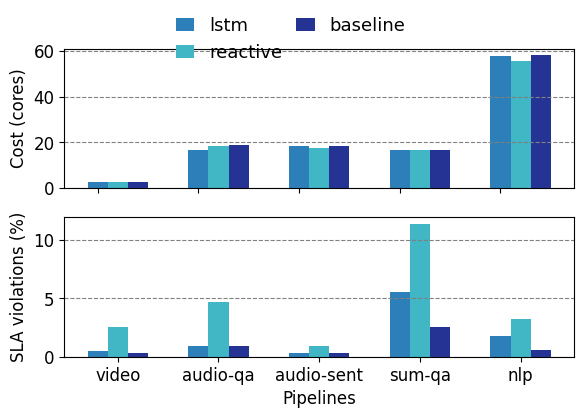

In [16]:
import importlib

importlib.reload(experiments.utils.drawing)

data = {"Cost (cores)": total_core_changes_total, "SLA violations (%)": timeout_dics}

bbox_to_anchor = (0.7, 2.55)

experiments.utils.drawing.draw_cumulative_with_grouping(
    data,
    series_meta=series_meta,
    xlabel=xlabel,
    filename=f"{FIGURES_PATH}/predictor-abelation-sla",
    colors=["#2c7fb8", "#41b6c4", "#253494"],
    bbox_to_anchor=bbox_to_anchor,
    bar_width=0.2,
)